## Imports

In [3]:
import os

import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as tfk
from tensorflow.compat.v1.keras.initializers import RandomNormal, TruncatedNormal
from tensorflow.compat.v1.keras.layers import (Input, Dense, Activation, Layer, Lambda,
                                     Concatenate)
from tensorflow.compat.v1.keras.models import Model, load_model
from tensorflow.compat.v1.keras.optimizers import Adam

from models import ConvNet, SoftBinaryDecisionTree
from models.utils import brand_new_tfsession, draw_tree
from tensorflow.keras.callbacks import EarlyStopping, Callback

tf.disable_v2_behavior()


sess = brand_new_tfsession()

Instructions for updating:
non-resource variables are not supported in the long term


## Zad. 1 
Podział danych na zbiory treningowe, walidacyjne i testowe.

In [4]:
# load MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# add channel dim
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

# hold out last 10000 training samples for validation
# x_valid, y_valid =  # TODO
# x_train, y_train =  # TODO

x_valid, y_valid = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)
# (50000, 28, 28, 1) (50000,) (10000, 28, 28, 1) (10000,) (10000, 28, 28, 1) (10000,)

(50000, 28, 28, 1) (50000,) (10000, 28, 28, 1) (10000,) (10000, 28, 28, 1) (10000,)


In [5]:
# retrieve image and label shapes from training data
img_rows, img_cols, img_chans = x_train.shape[1:]
n_classes = np.unique(y_train).shape[0]

print(img_rows, img_cols, img_chans, n_classes)

28 28 1 10


In [6]:
# convert labels to 1-hot vectors
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

print(y_train.shape, y_valid.shape, y_test.shape)

(50000, 10) (10000, 10) (10000, 10)


In [7]:
# normalize inputs and cast to float
x_train = (x_train / np.max(x_train)).astype(np.float32)
x_valid = (x_valid / np.max(x_valid)).astype(np.float32)
x_test = (x_test / np.max(x_test)).astype(np.float32)

### Neural Network
##### Sieci neuronowe jako model nauczyciela

In [8]:
nn = ConvNet(img_rows, img_cols, img_chans, n_classes)

In [9]:
nn = ConvNet(img_rows, img_cols, img_chans, n_classes)
nn.maybe_train(data_train=(x_train, y_train),
               data_valid=(x_valid, y_valid),
               batch_size=16, epochs=12)
nn.evaluate(x_train, y_train)

Loading trained model from assets/nn-model.hdf5.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
accuracy: 99.93% | loss: 0.003023036504798038


In [10]:
nn.evaluate(x_valid, y_valid)
nn.evaluate(x_test, y_test)

accuracy: 99.14% | loss: 0.03457641640711636
accuracy: 99.27% | loss: 0.02784054759651358


## Zad. 2 Extraction of soft labels for distillation
Wyekstrahować `soft labels` potrzebne do destylacji. Trzeba wykorzystać metodę klasy `ConvNet`.

In [11]:
# y_train_soft =  # TODO

y_train_soft = nn.predict(x_train)
y_train_soft.shape # (50000, 10)

(50000, 10)

## Zad. 3 Binary Soft Decision Tree
Należy wypłaszczyć zbiór danych.

((50000, 784), (10000, 784), (10000, 784))

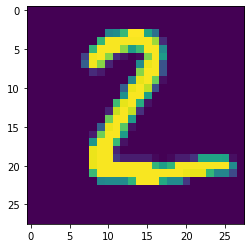

In [12]:
# x_train_flat =  # TODO
# x_valid_flat =  # TODO
# x_test_flat =  # TODO

x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_valid_flat = x_valid.reshape((x_valid.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_test_flat.reshape((x_test_flat.shape[0], img_rows, img_cols))[1])

x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape  # ((50000, 784), (10000, 784), (10000, 784))

<a id='hyperparameters'></a>
### Hyperparameters
* `tree_depth`: as denoted in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)], depth is in terms of inner nodes (excluding leaves / indexing depth from `0`)
* `penalty_strength`: regularization penalty strength
* `penalty_decay`: regularization penalty decay: paper authors found 0.5 optimal (note that $2^{-d} = 0.5^d$ as we use it)
* `ema_win_size`: scaling factor to the "default size of the window" used to calculate moving averages (growing exponentially with depth) of node and path probabilities
* `inv_temp`: scale logits of inner nodes to "avoid very soft decisions" [[paper](https://arxiv.org/pdf/1711.09784.pdf)]
    * pass `0` to indicate that this should be a learned parameter (single scalar learned to apply to all nodes in the tree)
* `learning_rate`: hopefully no need to explain, but let's be cool and use [Karpathy constant](https://www.urbandictionary.com/define.php?term=Karpathy%20Constant) ([source](https://twitter.com/karpathy/status/801621764144971776)) :D as default in `tree.__init__()`
* `batch_size`: we use a small one, because with increasing depth and thus amount of leaf bigots, larger batch sizes cause their loss terms to be scaled down too much by averaging, which results in poor optimization properties

In [13]:
n_features = img_rows * img_cols * img_chans
tree_depth = 4
penalty_strength = 1e+1
penalty_decay = 0.25
ema_win_size = 1000
inv_temp = 0.01
learning_rate = 5e-03
batch_size = 4

### Regular training with hard labels

In [14]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Use fn_output_signature instead
Built tree has 16 leaves out of 31 nodes


In [15]:
epochs = 40

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es], distill=False)

Loading trained model from assets/non-distilled/4/tree-model.
INFO:tensorflow:Restoring parameters from assets/non-distilled/4/tree-model


In [16]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

accuracy: 90.14% | loss: 8.06596018447876
accuracy: 89.16% | loss: 8.02870351047516


### Distillation: training with soft labels

In [17]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Built tree has 16 leaves out of 31 nodes


## Zad. 4
Wytrenuj drzewo z wykorzystaniem destylacji oraz `soft labels`.

In [18]:
epochs = 50

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

# TODO: wykorzystaj tej samej metody co w przypadku zwykłego drzewa (powyżej). Wykorzystaj również `soft labels`

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train_soft), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es], distill=True)

Loading trained model from assets/distilled/4/tree-model.
INFO:tensorflow:Restoring parameters from assets/distilled/4/tree-model


In [19]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

accuracy: 92.00% | loss: 7.287157012748718
accuracy: 91.40% | loss: 7.283791768264771


<a id='Wizualizacja'></a>
Zwizualizujmy sobie teraz jak drzewo rozpoznaje różne cyfry:

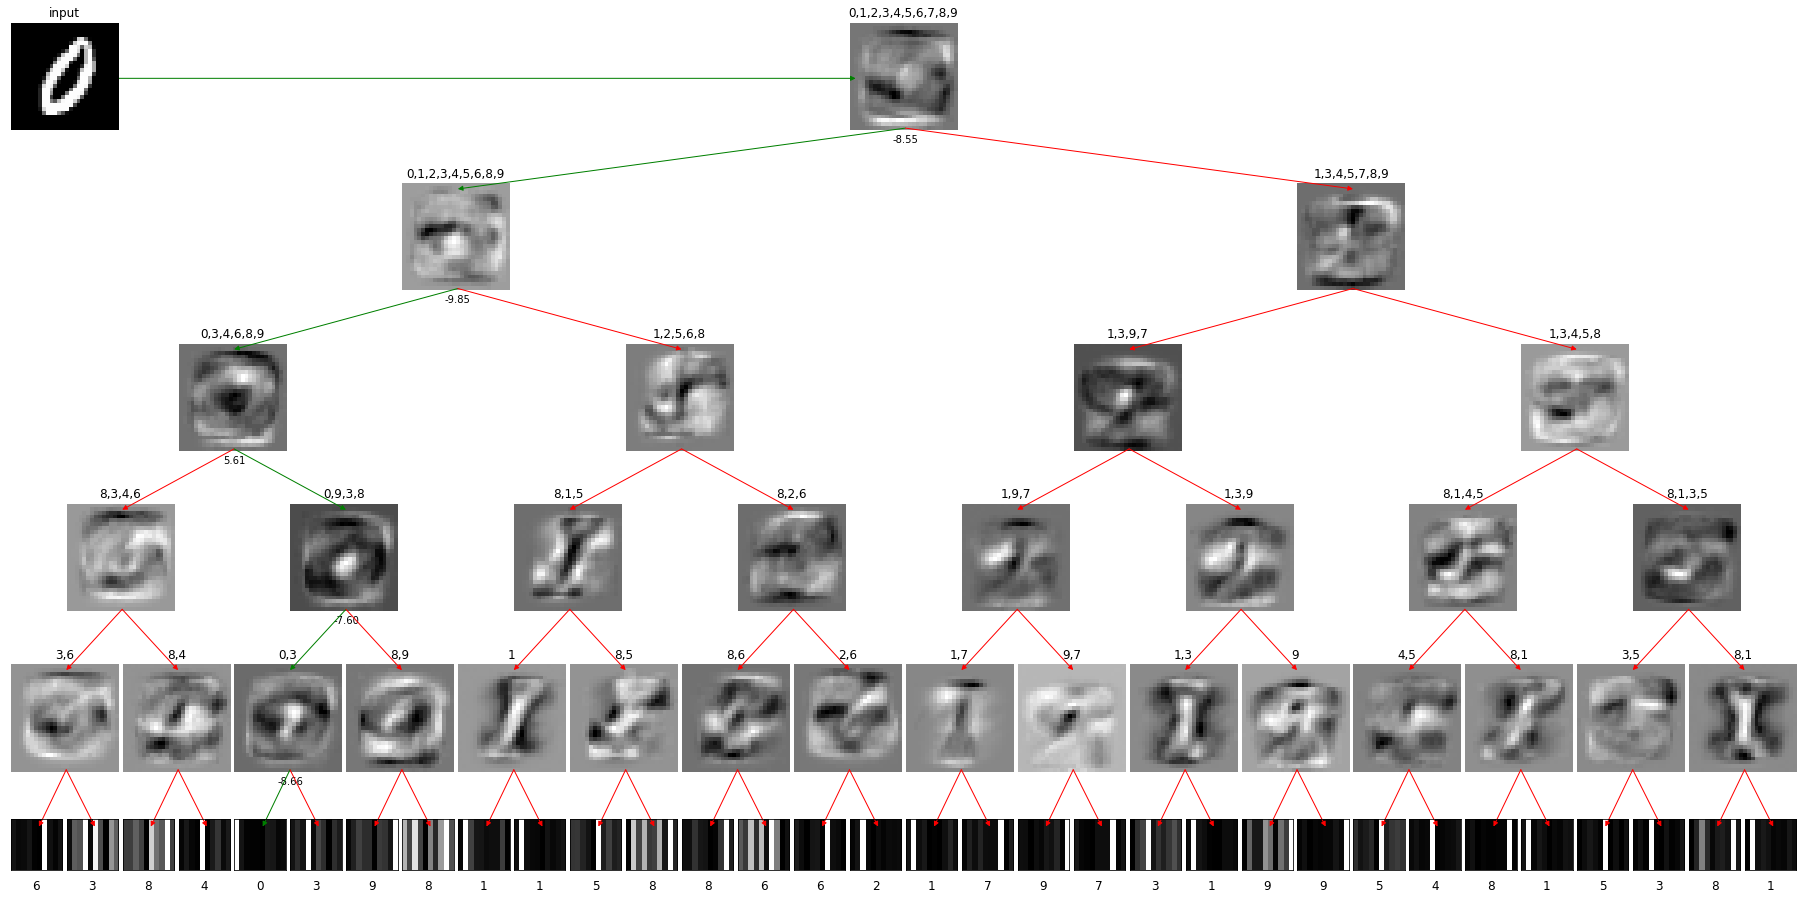

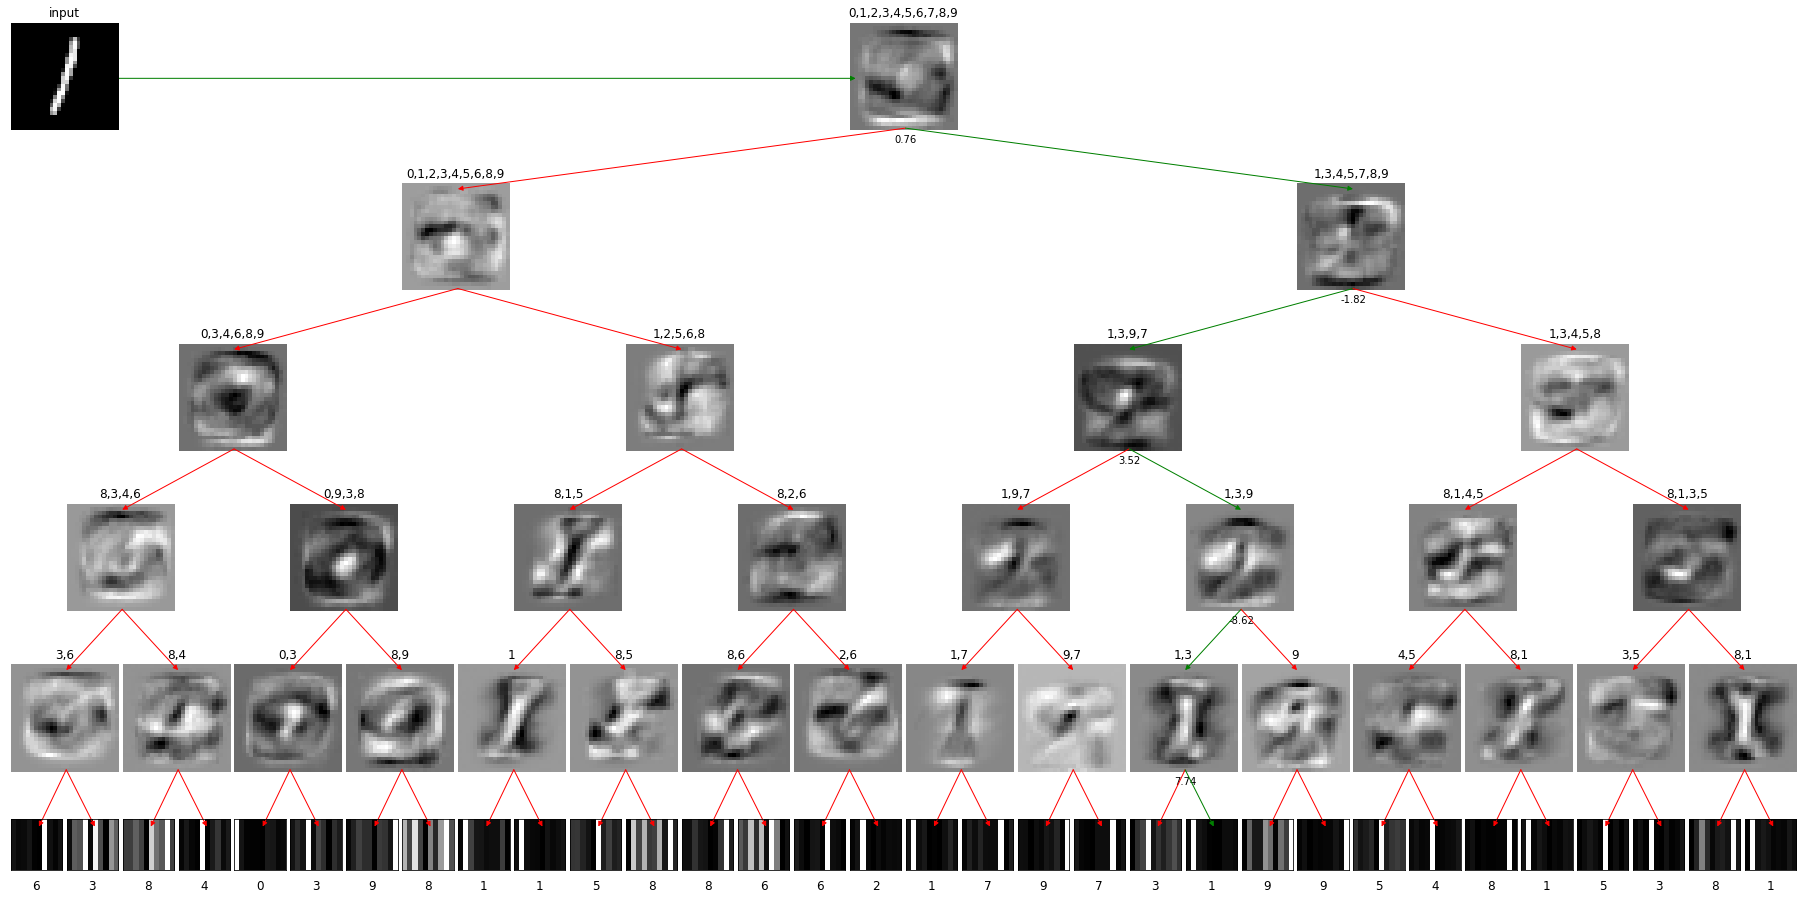

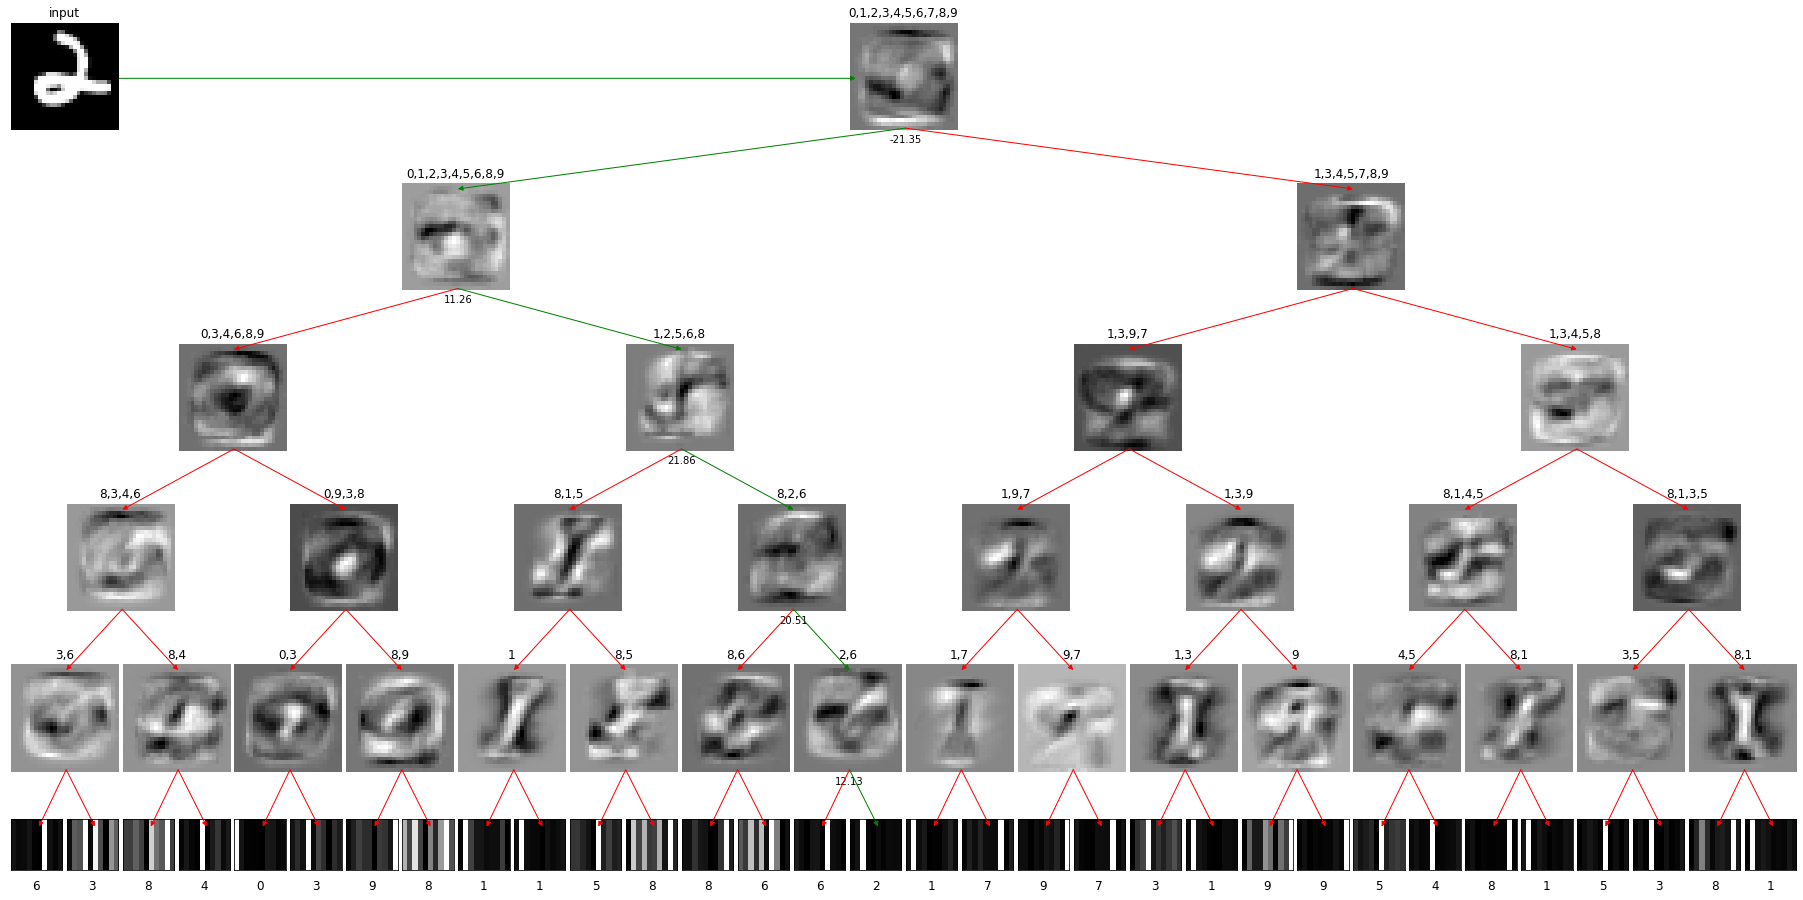

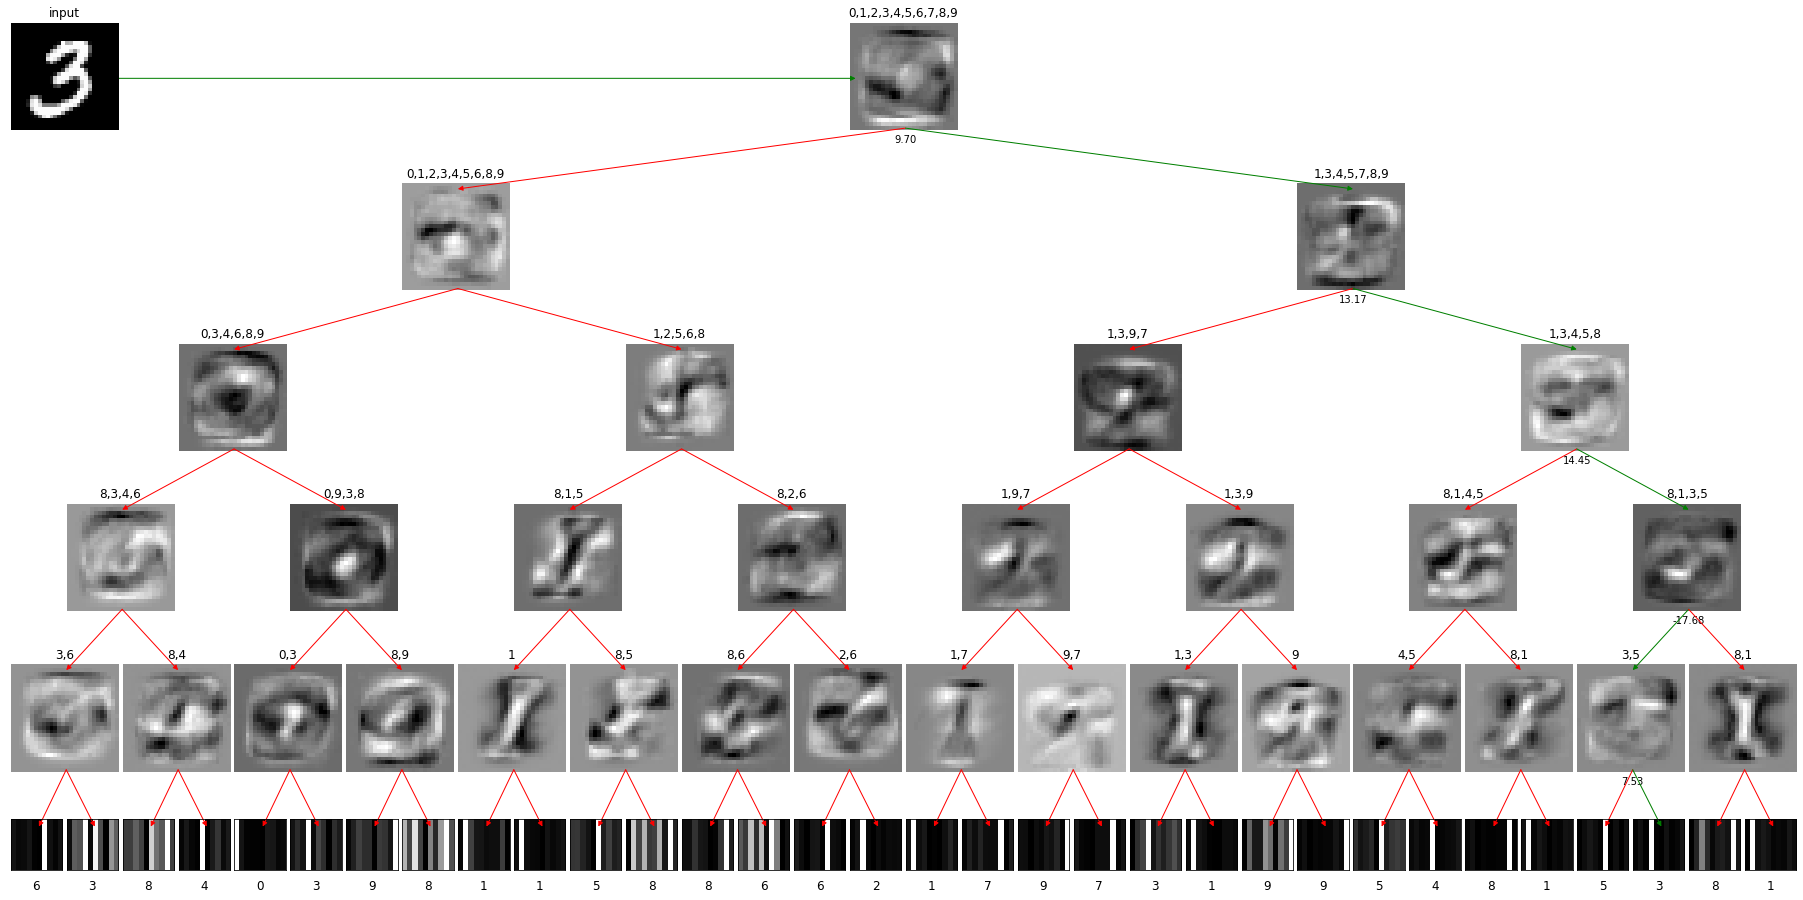

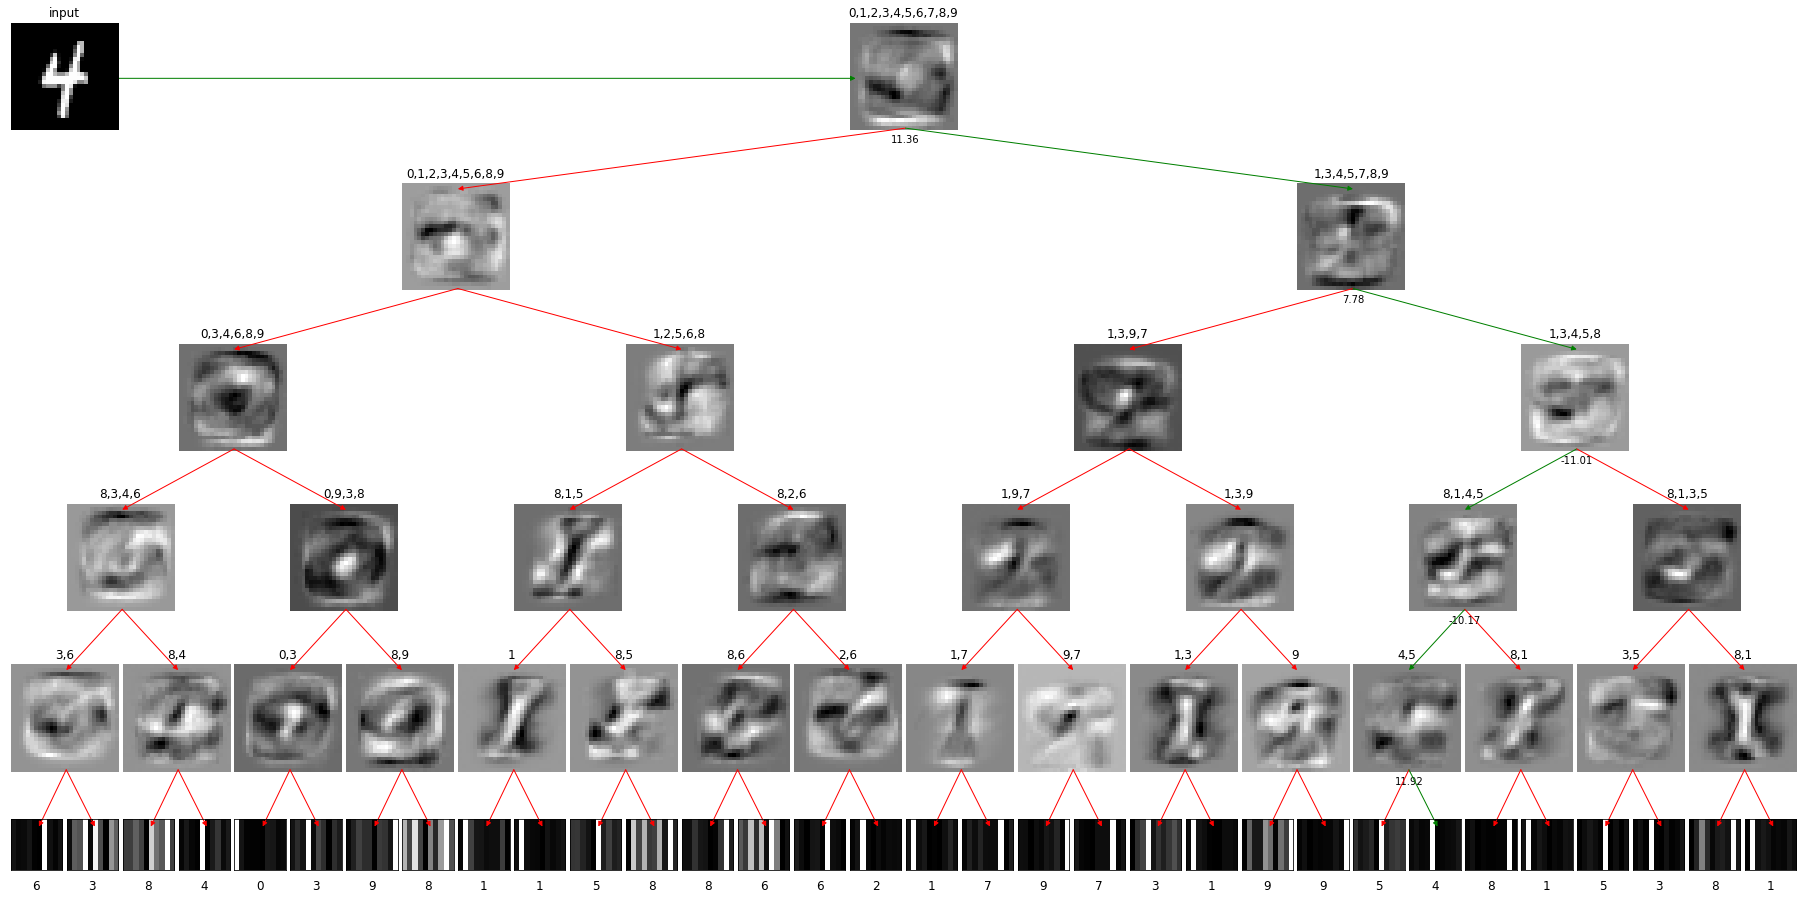

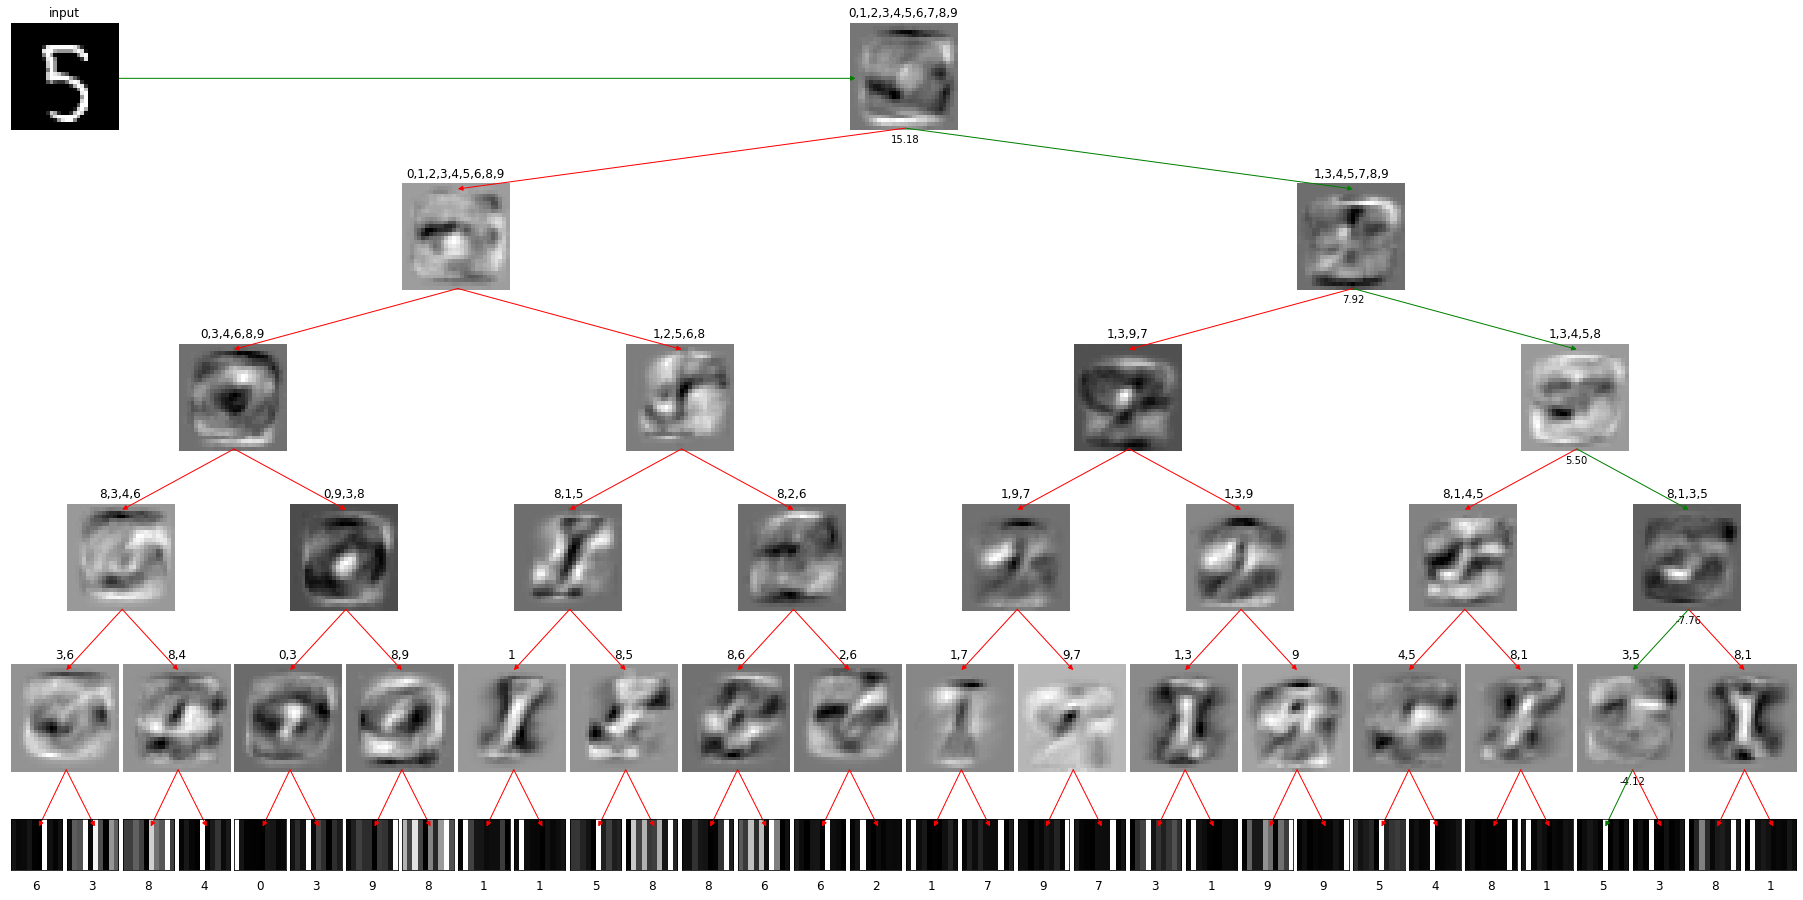

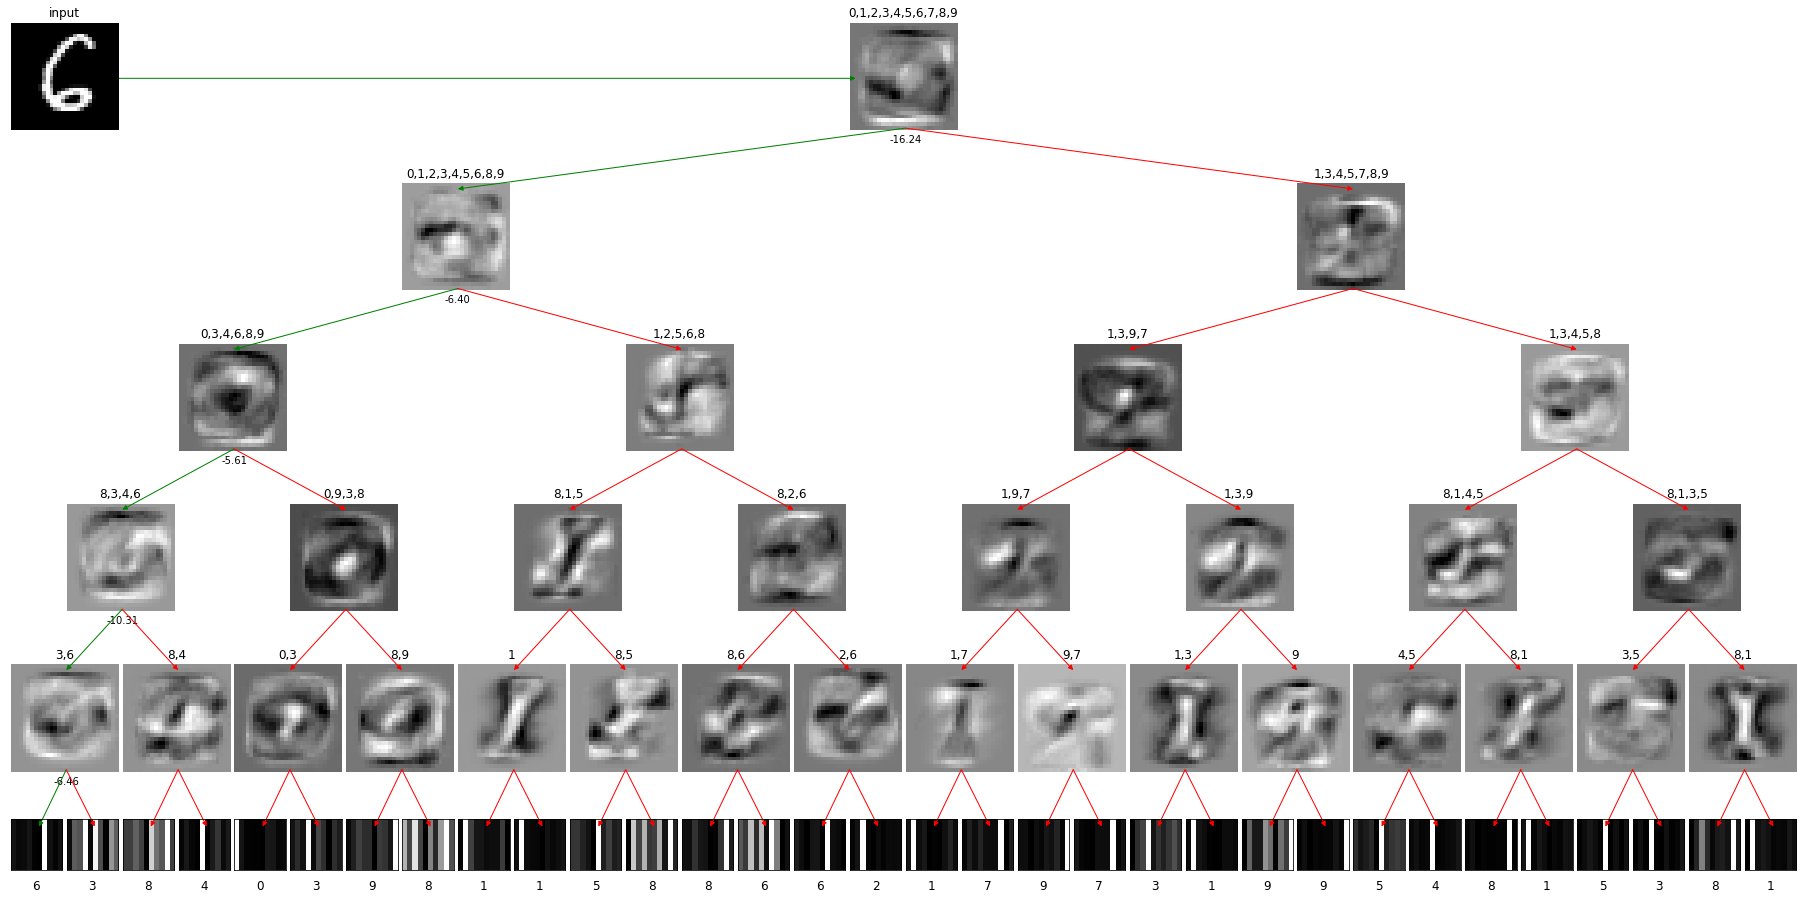

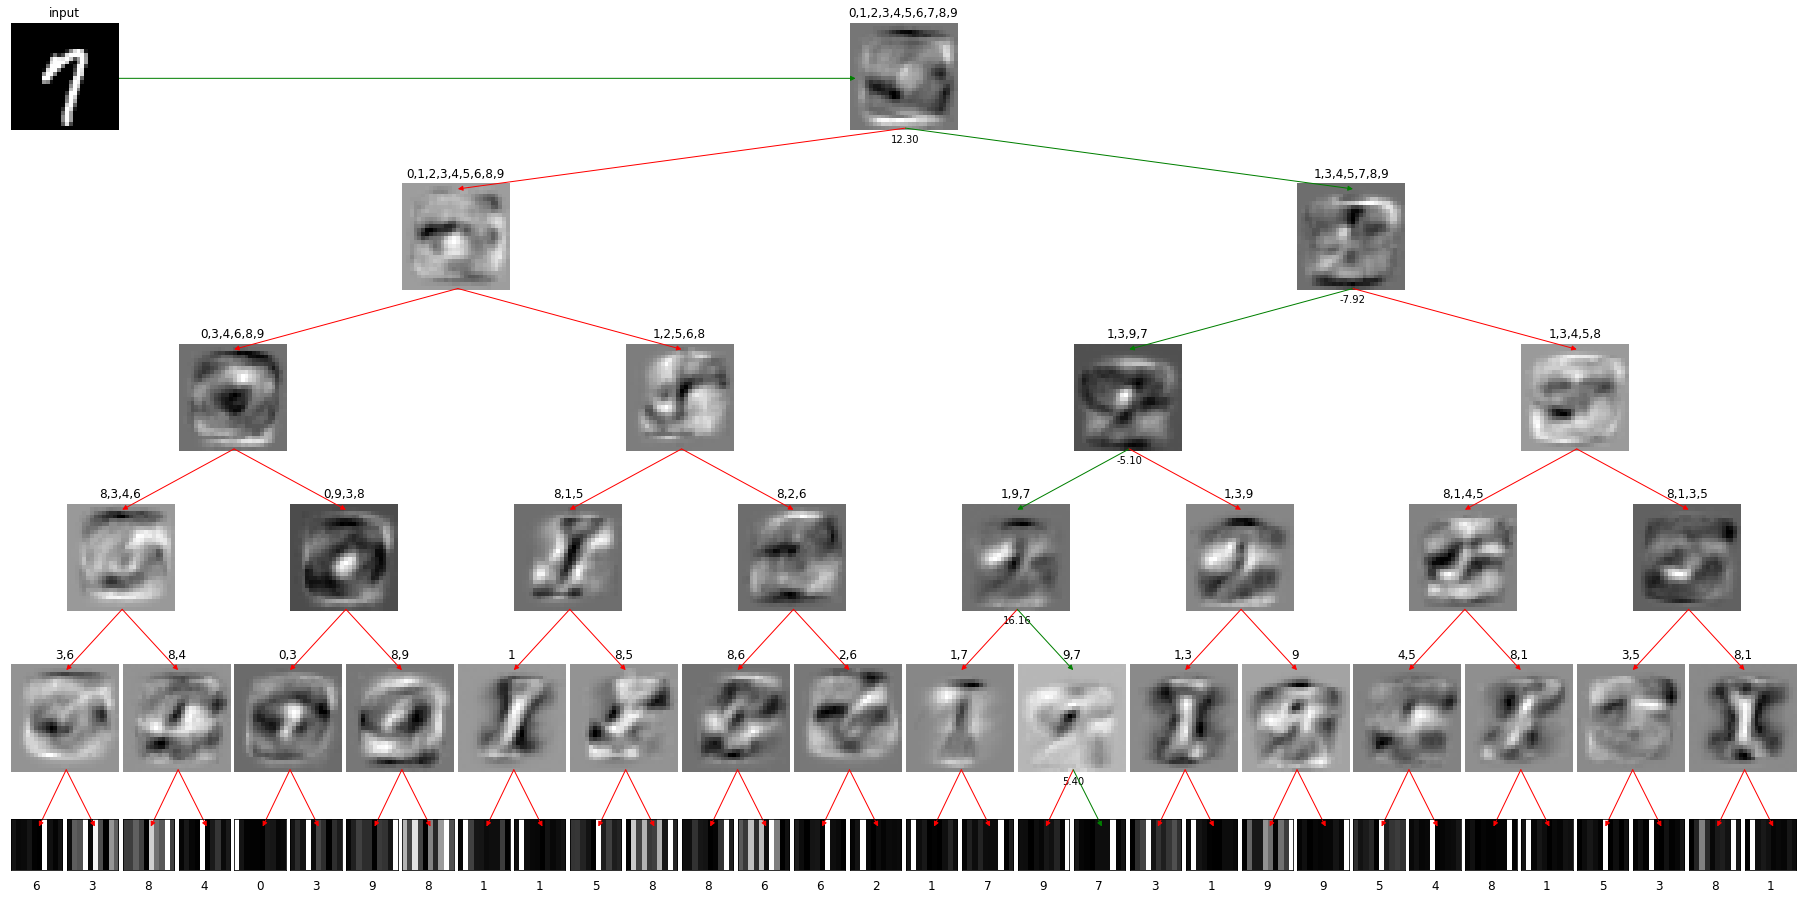

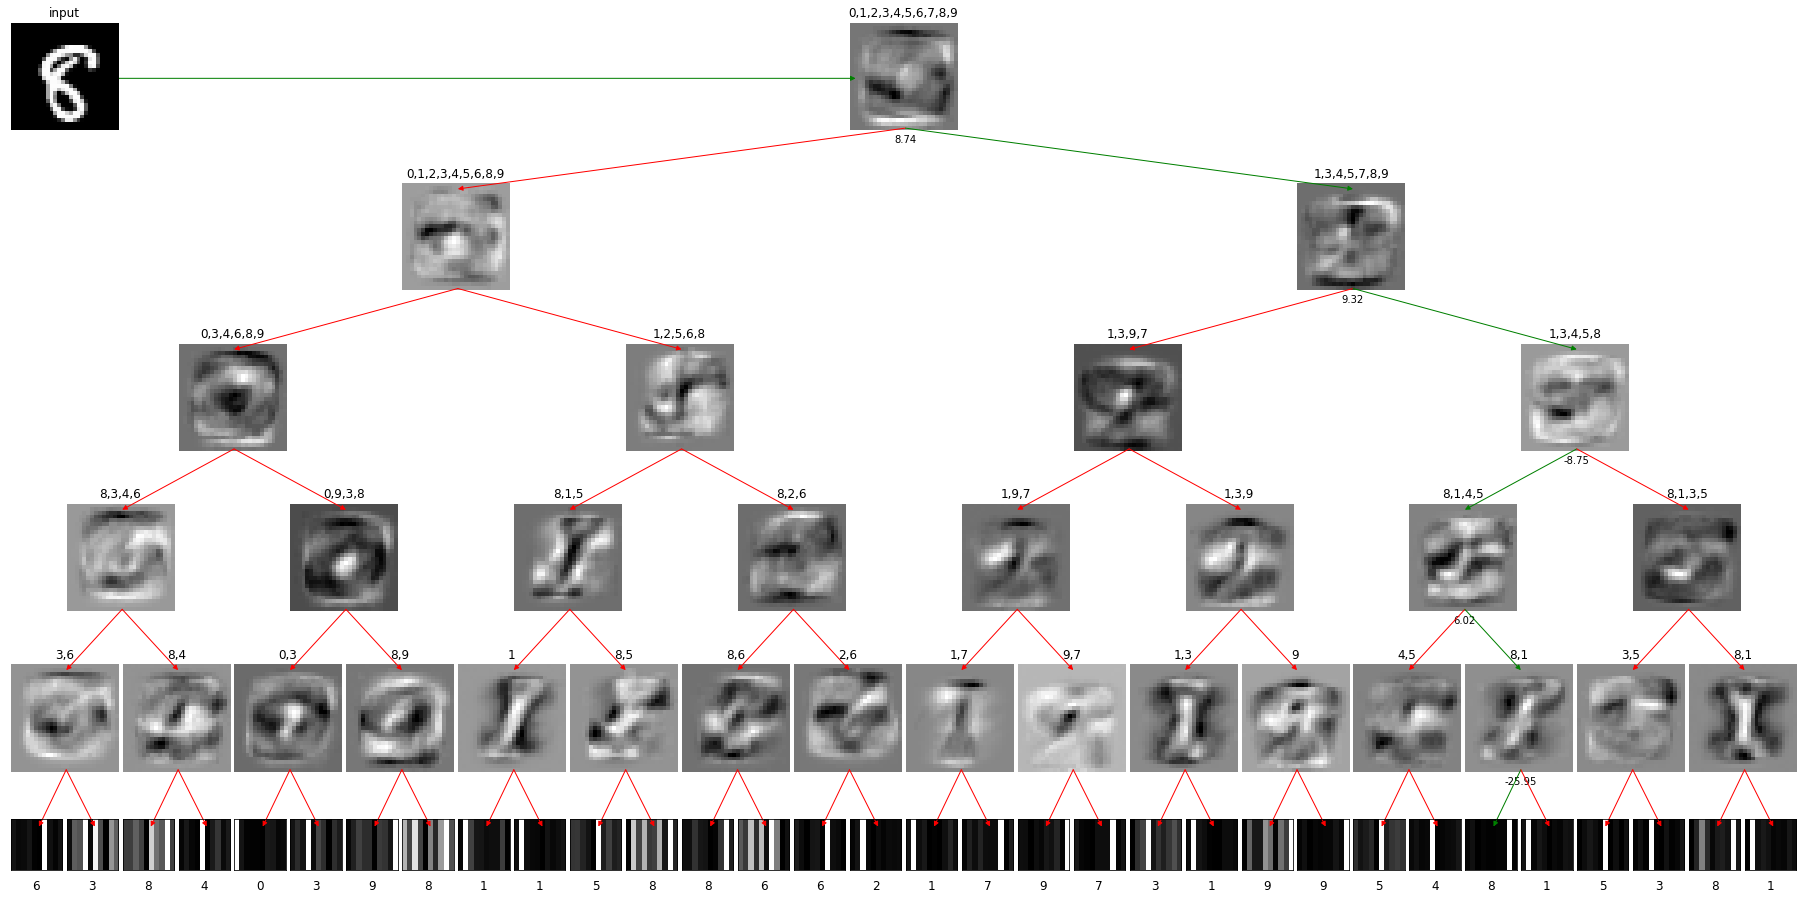

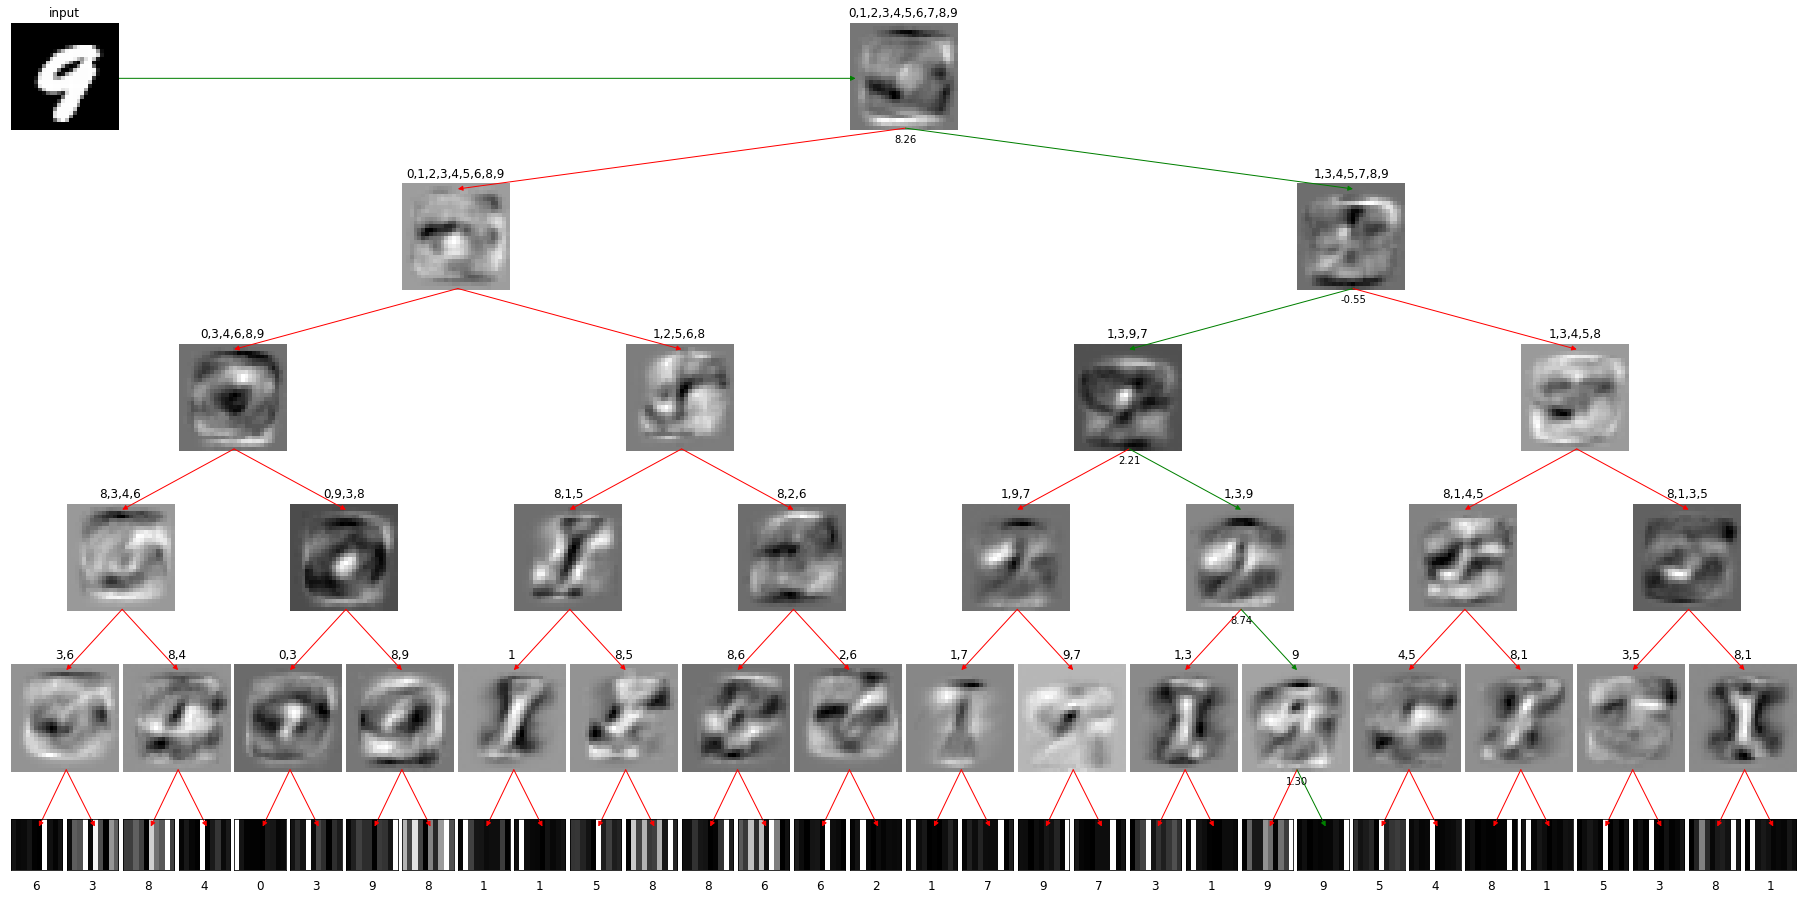

In [47]:
np.random.seed(0)

for digit in range(10):
    sample_index = np.random.choice(np.where(np.argmax(y_test, axis=1)==digit)[0])
    input_img = x_test[sample_index]
    draw_tree(sess, tree, img_rows, img_cols, img_chans, input_img=input_img)

## Pytanie kontrolne
##### Które z drzew daje lepsze rezultaty i o ile?

## Zad. 5
Wytrenuj drzewa o głębokości `tree_depth=[1, 2, 3, 5]` (dla `soft labels` oraz `hard labels`) i porównaj otrzymane rezultaty
z wcześniejszymi wynikami dla głębokości `tree_depth=4`. 
Można użyć funkcji [`draw_tree`](#Wizualizacja) (z zadania 4) dla każdego drzewa w celu zwizualizowania jego węzłów.

#### Zadanie dodatkowe:
Znaleźć optymalne wartości parametrów dla drzew decyzyjnych w przypadku zarówno `soft labels` jak i `hard labels` (modyfikując wartości parametrów opisanych w sekcji [Hyperparameters](#hyperparameters)). Przetestować drzewa dla większych wartości `tree_depth`.